In [141]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from models import functions

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [142]:
df = pd.read_csv('notebook/NRZ_history.csv', index_col=0)

In [143]:
df.head()

,close,volume,vwap,changeOverTime
2015-05-18,17.45,1611500.0,17.38000,0.01159
2015-05-19,17.78,2060800.0,17.70000,0.01716
2015-05-20,17.64,2145700.0,17.69000,-0.00899
2015-05-21,17.20,1205200.0,17.20000,-0.00232
2015-05-22,17.39,1476200.0,17.31667,0.01340


In [144]:
TRAIN_SPLIT = int(len(df)*0.8)

In [145]:
TRAIN_SPLIT

1007

In [146]:
# constants 
EVALUATION_INTERVAL = 200
EPOCHS = 10

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [147]:
features_considered = ['close', 'vwap']

close      vwap
2015-05-18  17.45  17.38000
2015-05-19  17.78  17.70000
2015-05-20  17.64  17.69000
2015-05-21  17.20  17.20000
2015-05-22  17.39  17.31667
...           ...       ...
2020-05-11   6.31   6.34667
2020-05-12   6.11   6.19333
2020-05-13   5.66   5.71667
2020-05-14   6.09   5.83333
2020-05-15   5.91   5.98667

[1259 rows x 2 columns]


,close,vwap
2015-05-18,17.45,17.38000
2015-05-19,17.78,17.70000
2015-05-20,17.64,17.69000
2015-05-21,17.20,17.20000
2015-05-22,17.39,17.31667


2015-05-18    17.45
2015-05-19    17.78
2015-05-20    17.64
2015-05-21    17.20
2015-05-22    17.39
              ...  
2020-05-11     6.31
2020-05-12     6.11
2020-05-13     5.66
2020-05-14     6.09
2020-05-15     5.91
Name: close, Length: 1259, dtype: float64


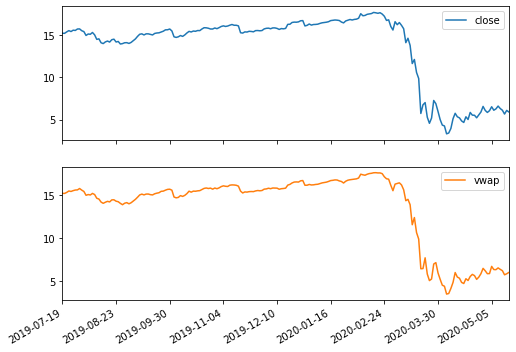

In [148]:
features = df[features_considered]
print(features)
features[1050:].plot(subplots=True)
display(features.head())
print(features.iloc[:, 0])

In [149]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [150]:
# dataset = (dataset-data_mean)/data_std

In [151]:
dataset[:, 0]

array([17.45, 17.78, 17.64, ...,  5.66,  6.09,  5.91])

In [152]:
past_history = 100 # how many past days to consider
future_target = 5 # how many days to predict in the future 
STEP = 1

x_train_single, y_train_single = functions.multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = functions.multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [153]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('\n Target price to predict : {}'.format(y_train_single[0].shape))

Single window of past history : (100, 2)

 Target price to predict : ()


In [154]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [155]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [156]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(147, 1)


In [157]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 18s 92ms/step - loss: 7.1846 - val_loss: 3.5581
Epoch 2/10
200/200 [==============================] - 31s 157ms/step - loss: 1.0186 - val_loss: 1.8689
Epoch 3/10
200/200 [==============================] - 26s 128ms/step - loss: 0.4874 - val_loss: 2.2328
Epoch 4/10
200/200 [==============================] - 30s 149ms/step - loss: 0.4425 - val_loss: 1.8265
Epoch 5/10
200/200 [==============================] - 35s 176ms/step - loss: 0.4212 - val_loss: 2.0959
Epoch 6/10
200/200 [==============================] - 34s 171ms/step - loss: 0.4077 - val_loss: 1.9161
Epoch 7/10
200/200 [==============================] - 34s 171ms/step - loss: 0.3985 - val_loss: 1.8492
Epoch 8/10
200/200 [==============================] - 34s 172ms/step - loss: 0.3902 - val_loss: 1.8225
Epoch 9/10
200/200 [==============================] - 35s 175ms/step - loss: 0.3821 - val_loss: 1.8438
Epoch 10/10
200/200 [==========

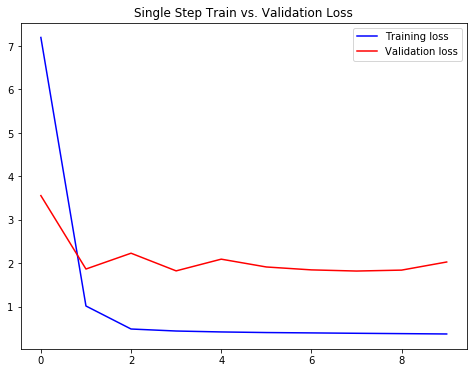

In [160]:
functions.plot_train_history(single_step_history, 'Single Step Train vs. Validation Loss')

In [165]:
print(val_data_single)

<RepeatDataset shapes: ((None, 100, 2), (None,)), types: (tf.float64, tf.float64)>


[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25, 15.48, 15.85, 15.72, 15.74, 15.13, 15.32, 15.36, 15.42,
       15.55, 15.46, 15.58, 15.77, 15.84, 15.83, 15.89, 16.01, 15.64,
       15.72, 15.84, 15.39, 15.46, 15.33, 15.42, 15.56, 15.4 , 15.3 ,
       15.3 , 15.29, 15.41, 15.45, 15.37, 15.28, 15.04, 15.18, 15.17,
       15.34, 15.49, 15.38, 15.54, 15.51, 15.68, 15.69, 15.48, 15.37,
       14.92, 15.09, 15.06, 15.27, 14.99, 14.46, 14.52, 14.06, 13.96,
       14.16, 14.26, 14.14, 14.42, 14.48, 14.15, 14.21, 13.91, 13.96,
       14.06, 14.07, 13.98, 14.1 , 14.31, 14.51, 14.81, 15.06, 15.11,
       14.98, 15.11, 15.11, 15.05, 14.98, 15.16, 15.21, 15.23, 15.33,
       15.42, 15.58, 15.59, 15.68, 15.45, 14.76, 14.69, 14.76, 14.91,
       14.81]), 15.41, array([15.808513], dtype=float32)]


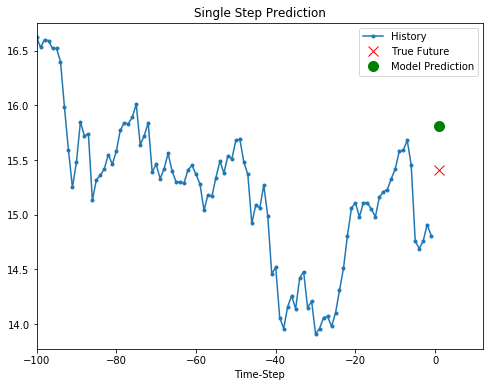

[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25, 15.48, 15.85, 15.72, 15.74, 15.13, 15.32, 15.36, 15.42,
       15.55, 15.46, 15.58, 15.77, 15.84, 15.83, 15.89, 16.01, 15.64,
       15.72, 15.84, 15.39, 15.46, 15.33, 15.42, 15.56, 15.4 , 15.3 ,
       15.3 , 15.29, 15.41, 15.45, 15.37, 15.28, 15.04, 15.18, 15.17,
       15.34, 15.49, 15.38, 15.54, 15.51, 15.68, 15.69, 15.48, 15.37,
       14.92, 15.09, 15.06, 15.27, 14.99, 14.46, 14.52, 14.06, 13.96,
       14.16, 14.26, 14.14, 14.42, 14.48, 14.15, 14.21, 13.91, 13.96,
       14.06, 14.07, 13.98, 14.1 , 14.31, 14.51, 14.81, 15.06, 15.11,
       14.98, 15.11, 15.11, 15.05, 14.98, 15.16, 15.21, 15.23, 15.33,
       15.42, 15.58, 15.59, 15.68, 15.45, 14.76, 14.69, 14.76, 14.91,
       14.81]), 15.41, array([15.808513], dtype=float32)]


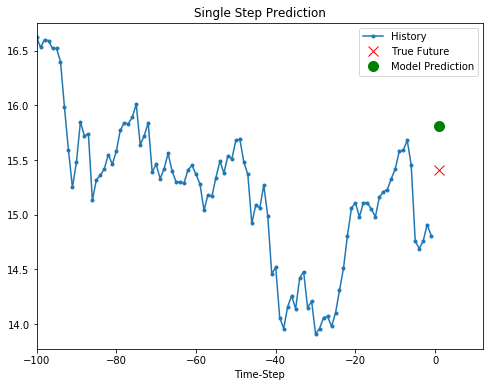

[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25, 15.48, 15.85, 15.72, 15.74, 15.13, 15.32, 15.36, 15.42,
       15.55, 15.46, 15.58, 15.77, 15.84, 15.83, 15.89, 16.01, 15.64,
       15.72, 15.84, 15.39, 15.46, 15.33, 15.42, 15.56, 15.4 , 15.3 ,
       15.3 , 15.29, 15.41, 15.45, 15.37, 15.28, 15.04, 15.18, 15.17,
       15.34, 15.49, 15.38, 15.54, 15.51, 15.68, 15.69, 15.48, 15.37,
       14.92, 15.09, 15.06, 15.27, 14.99, 14.46, 14.52, 14.06, 13.96,
       14.16, 14.26, 14.14, 14.42, 14.48, 14.15, 14.21, 13.91, 13.96,
       14.06, 14.07, 13.98, 14.1 , 14.31, 14.51, 14.81, 15.06, 15.11,
       14.98, 15.11, 15.11, 15.05, 14.98, 15.16, 15.21, 15.23, 15.33,
       15.42, 15.58, 15.59, 15.68, 15.45, 14.76, 14.69, 14.76, 14.91,
       14.81]), 15.41, array([15.808513], dtype=float32)]


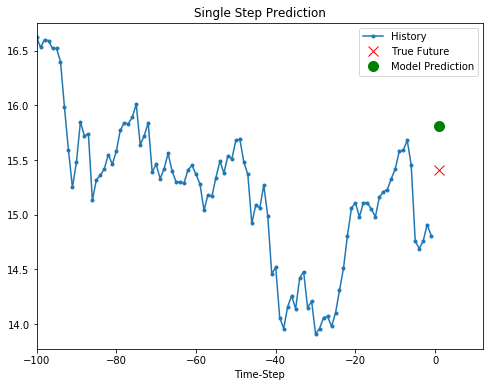

In [164]:
for x, y in val_data_single.take(3):
    print([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]])
    plot = functions.show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
    plot.show()